In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import os, glob, time, math, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms, datasets
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# -----------------------
# Config
# -----------------------
@dataclass
class CFG:
    # Folder with class subfolders
    ROOT_TRAIN: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
    IMAGE_EXTS: Tuple[str,...] = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")

    img_size: int = 224
    batch_size: int = 32
    epochs: int = 50

    # Kaggle/Colab-friendly dataloader
    num_workers: int = 0
    pin_memory: bool = False

    # Optim / BYOL
    lr: float = 3e-4
    weight_decay: float = 1e-4
    ema_base_m: float = 0.996
    proj_dim: int = 256
    hidden_dim: int = 4096

    seed: int = 42

    # t-SNE options
    MAX_TSNE_IMAGES: Optional[int] = 1500   # reduce if slow/OOM; set None for all images
    TSNE_COLOR_BY_LABELS: bool = True       # color by TRUE labels & save 'byol_tsne_by_label.png'

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.benchmark = True
set_seed(cfg.seed)

# -----------------------
# Unlabeled BYOL Dataset
# -----------------------
class TwoViewTransform:
    """BYOL-style strong augmentations (two stochastic views)."""
    def __init__(self, size):
        self.t = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.2,0.1)], p=0.8),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    def __call__(self, img):
        return self.t(img), self.t(img)

class UnlabeledRecursive(Dataset):
    """Recursively collects image paths; returns two augmented views; NO labels."""
    def __init__(self, root, size, exts):
        self.paths: List[str] = []
        for ext in exts:
            self.paths.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found under: {root}")
        self.view = TwoViewTransform(size)
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        with Image.open(p) as im:
            img = im.convert("RGB")
        v1, v2 = self.view(img)
        return v1, v2

train_ds = UnlabeledRecursive(cfg.ROOT_TRAIN, cfg.img_size, cfg.IMAGE_EXTS)
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    drop_last=True
)

# -----------------------
# BYOL Model
# -----------------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out, bias=False),
            nn.BatchNorm1d(out, affine=False)
        )
    def forward(self, x): return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, dim)
        )
    def forward(self, x): return self.net(x)

def get_backbone():
    enc = models.resnet50(weights=None)  # from scratch; swap if desired
    feat = enc.fc.in_features
    enc.fc = nn.Identity()               # global pool -> 2048-d features
    return enc, feat

class BYOL(nn.Module):
    def __init__(self, proj_dim=256, hidden=4096):
        super().__init__()
        self.online_enc, feat = get_backbone()
        self.online_proj = ProjectionHead(feat, hidden, proj_dim)
        self.online_pred = PredictionHead(proj_dim, hidden)

        self.target_enc, _ = get_backbone()
        self.target_proj = ProjectionHead(feat, hidden, proj_dim)

        # init target as EMA copy of online
        for t, s in zip(self.target_enc.parameters(), self.online_enc.parameters()):
            t.data.copy_(s.data); t.requires_grad = False
        for t, s in zip(self.target_proj.parameters(), self.online_proj.parameters()):
            t.data.copy_(s.data); t.requires_grad = False

    @torch.no_grad()
    def update_target(self, m):
        for t, s in zip(self.target_enc.parameters(), self.online_enc.parameters()):
            t.data.mul_(m).add_(s.data, alpha=1-m)
        for t, s in zip(self.target_proj.parameters(), self.online_proj.parameters()):
            t.data.mul_(m).add_(s.data, alpha=1-m)

    def forward(self, x1, x2, m):
        # online
        q1 = self.online_pred(self.online_proj(self.online_enc(x1)))
        q2 = self.online_pred(self.online_proj(self.online_enc(x2)))
        # target (no grad)
        with torch.no_grad():
            k1 = self.target_proj(self.target_enc(x1))
            k2 = self.target_proj(self.target_enc(x2))
        # normalize
        q1 = F.normalize(q1, dim=-1); q2 = F.normalize(q2, dim=-1)
        k1 = F.normalize(k1, dim=-1); k2 = F.normalize(k2, dim=-1)
        # BYOL loss
        def byol_loss(a, b): return 2 - 2*(a*b).sum(dim=-1).mean()
        loss = byol_loss(q1, k2) + byol_loss(q2, k1)
        self.update_target(m)
        return loss

def momentum_schedule(m0, epoch, max_epochs):
    return 1 - (1-m0)*(0.5*(1+math.cos(math.pi*epoch/max_epochs)))

model = BYOL(cfg.proj_dim, cfg.hidden_dim).to(device)
optimizer = torch.optim.AdamW([
    {"params": model.online_enc.parameters()},
    {"params": model.online_proj.parameters()},
    {"params": model.online_pred.parameters()},
], lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def lr_at(e):
    base, final = cfg.lr, cfg.lr*0.01
    if cfg.epochs <= 1: return base
    t = e/(cfg.epochs-1)
    return final + (base-final)*0.5*(1+math.cos(math.pi*t))

# -----------------------
# Train
# -----------------------
loss_history = []

for epoch in range(cfg.epochs):
    for pg in optimizer.param_groups:
        pg["lr"] = lr_at(epoch)
    m = momentum_schedule(cfg.ema_base_m, epoch, cfg.epochs)

    model.train()
    running, t0 = 0.0, time.time()
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{cfg.epochs}")
    for v1, v2 in pbar:
        v1 = v1.to(device, non_blocking=False); v2 = v2.to(device, non_blocking=False)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            loss = model(v1, v2, m)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        running += loss.item()
        avg = running / (pbar.n if pbar.n > 0 else 1)
        pbar.set_postfix({"loss": f"{avg:.4f}"})
    loss_history.append(avg)
    print(f"Epoch {epoch+1}/{cfg.epochs} | avg_loss={avg:.4f} | time={time.time()-t0:.1f}s")

# Save encoder for downstream tasks
torch.save(model.online_enc.state_dict(), "byol_encoder.pth")
print("✅ BYOL pretrained encoder saved as 'byol_encoder.pth'")


/tmp/ipykernel_36/2139249034.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/50:   0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_36/2139249034.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/50 | avg_loss=3.0849 | time=158.7s


Epoch 2/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/50 | avg_loss=2.0930 | time=159.8s


Epoch 3/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/50 | avg_loss=1.6713 | time=160.1s


Epoch 4/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/50 | avg_loss=1.6243 | time=160.4s


Epoch 5/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/50 | avg_loss=1.5354 | time=162.6s


Epoch 6/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/50 | avg_loss=1.4584 | time=168.5s


Epoch 7/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/50 | avg_loss=1.4455 | time=163.8s


Epoch 8/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/50 | avg_loss=1.5336 | time=163.4s


Epoch 9/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/50 | avg_loss=1.6745 | time=163.5s


Epoch 10/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/50 | avg_loss=1.6956 | time=164.7s


Epoch 11/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/50 | avg_loss=1.7125 | time=162.2s


Epoch 12/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/50 | avg_loss=1.6202 | time=159.6s


Epoch 13/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/50 | avg_loss=1.7250 | time=162.3s


Epoch 14/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/50 | avg_loss=1.7298 | time=163.0s


Epoch 15/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/50 | avg_loss=1.6548 | time=162.2s


Epoch 16/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/50 | avg_loss=1.6223 | time=161.7s


Epoch 17/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/50 | avg_loss=1.5235 | time=165.0s


Epoch 18/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/50 | avg_loss=1.6120 | time=168.1s


Epoch 19/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 19/50 | avg_loss=1.5379 | time=161.7s


Epoch 20/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 20/50 | avg_loss=1.4762 | time=162.8s


Epoch 21/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 21/50 | avg_loss=1.4833 | time=166.1s


Epoch 22/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 22/50 | avg_loss=1.4717 | time=159.7s


Epoch 23/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 23/50 | avg_loss=1.4114 | time=164.6s


Epoch 24/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 24/50 | avg_loss=1.3688 | time=165.6s


Epoch 25/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 25/50 | avg_loss=1.4046 | time=166.5s


Epoch 26/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 26/50 | avg_loss=1.3126 | time=162.4s


Epoch 27/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 27/50 | avg_loss=1.2257 | time=166.1s


Epoch 28/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 28/50 | avg_loss=1.3043 | time=167.3s


Epoch 29/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 29/50 | avg_loss=1.2346 | time=166.9s


Epoch 30/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 30/50 | avg_loss=1.2559 | time=164.4s


Epoch 31/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 31/50 | avg_loss=1.2252 | time=166.3s


Epoch 32/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 32/50 | avg_loss=1.1682 | time=169.3s


Epoch 33/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 33/50 | avg_loss=1.2109 | time=167.5s


Epoch 34/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 34/50 | avg_loss=1.2090 | time=166.1s


Epoch 35/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 35/50 | avg_loss=1.1749 | time=167.5s


Epoch 36/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 36/50 | avg_loss=1.0706 | time=164.4s


Epoch 37/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 37/50 | avg_loss=1.1057 | time=164.9s


Epoch 38/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 38/50 | avg_loss=1.1773 | time=164.2s


Epoch 39/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 39/50 | avg_loss=1.0998 | time=158.7s


Epoch 40/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 40/50 | avg_loss=1.1560 | time=163.1s


Epoch 41/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 41/50 | avg_loss=1.1139 | time=162.2s


Epoch 42/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 42/50 | avg_loss=1.1450 | time=165.0s


Epoch 43/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 43/50 | avg_loss=1.1052 | time=161.9s


Epoch 44/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 44/50 | avg_loss=1.1110 | time=162.6s


Epoch 45/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 45/50 | avg_loss=1.0494 | time=158.2s


Epoch 46/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 46/50 | avg_loss=1.0771 | time=158.3s


Epoch 47/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 47/50 | avg_loss=1.1453 | time=163.7s


Epoch 48/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 48/50 | avg_loss=1.0533 | time=162.6s


Epoch 49/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 49/50 | avg_loss=1.1036 | time=160.8s


Epoch 50/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 50/50 | avg_loss=1.1611 | time=166.3s
✅ BYOL pretrained encoder saved as 'byol_encoder.pth'


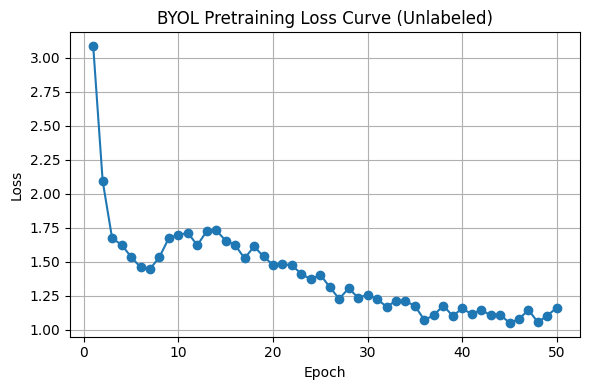

📈 Loss curve saved as 'byol_loss_curve.png'


In [8]:
# Plot & save loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("BYOL Pretraining Loss Curve (Unlabeled)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
plt.tight_layout()
plt.savefig("byol_loss_curve.png", dpi=300)
plt.show()
print("📈 Loss curve saved as 'byol_loss_curve.png'")

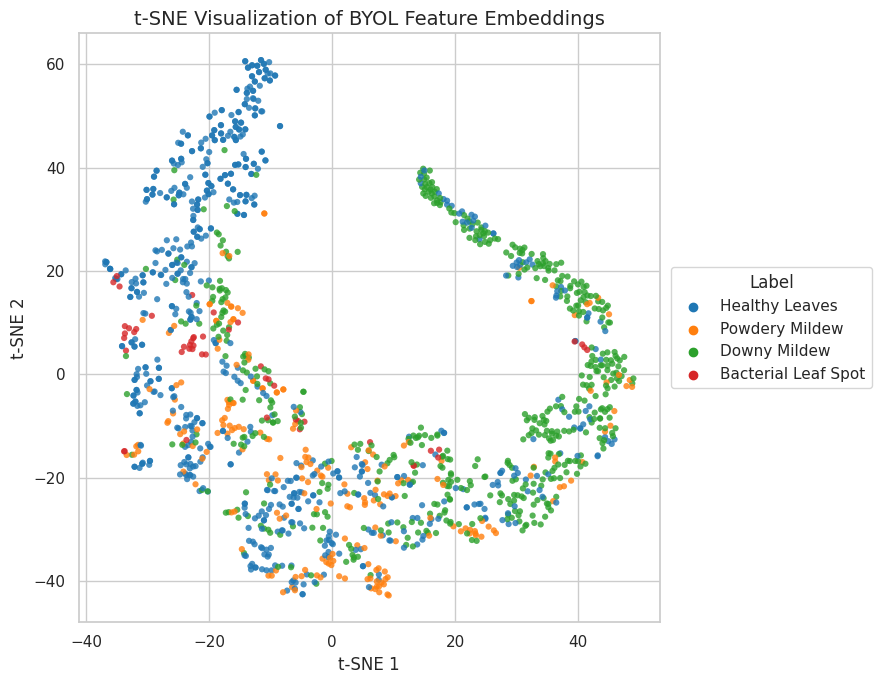

✅ t-SNE plot saved as 'byol_tsne_by_label.png' and shown inline


In [17]:
# ======================
# t-SNE on BYOL features (Corrected & Polished)
# ======================
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from torch.utils.data import Subset

# 1) Use a labeled split so we can color by class
ROOT_LABELED = cfg.ROOT_TRAIN  # or cfg.PATH_VALID if you want validation set

eval_tf = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

labeled_ds = datasets.ImageFolder(ROOT_LABELED, transform=eval_tf)

# Optional subsample for speed
idxs = list(range(len(labeled_ds)))
if cfg.MAX_TSNE_IMAGES is not None and len(idxs) > cfg.MAX_TSNE_IMAGES:
    idxs = random.sample(idxs, cfg.MAX_TSNE_IMAGES)

subset = Subset(labeled_ds, idxs)
loader = DataLoader(subset, batch_size=64, shuffle=False,
                    num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# 2) Extract features with the pretrained encoder
enc = model.online_enc.to(device).eval()   # BYOL encoder
for p in enc.parameters(): 
    p.requires_grad = False

features, labels = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        f = enc(x)                 # (B, 2048) for ResNet50 with fc=Identity()
        features.append(f.cpu().numpy())
        labels.append(y.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# 3) t-SNE
tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    random_state=cfg.seed
).fit_transform(features)

# 4) DataFrame for plotting
df = pd.DataFrame(tsne_2d, columns=["x", "y"])
class_names = labeled_ds.classes
df["label"] = [class_names[i] for i in labels]

# 5) Plot (prettier style)
plt.figure(figsize=(9, 7))
sns.set(style="whitegrid", context="notebook")
sns.scatterplot(
    data=df, x="x", y="y", hue="label",
    s=20, alpha=0.8, palette="tab10", edgecolor="none"
)
plt.title("t-SNE Visualization of BYOL Feature Embeddings", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Label", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.0)
plt.tight_layout()

# Save + show
plt.savefig("byol_tsne_by_label.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ t-SNE plot saved as 'byol_tsne_by_label.png' and shown inline")


Silhouette (PCA 2D):  -0.143
Silhouette (t-SNE 2D): -0.091


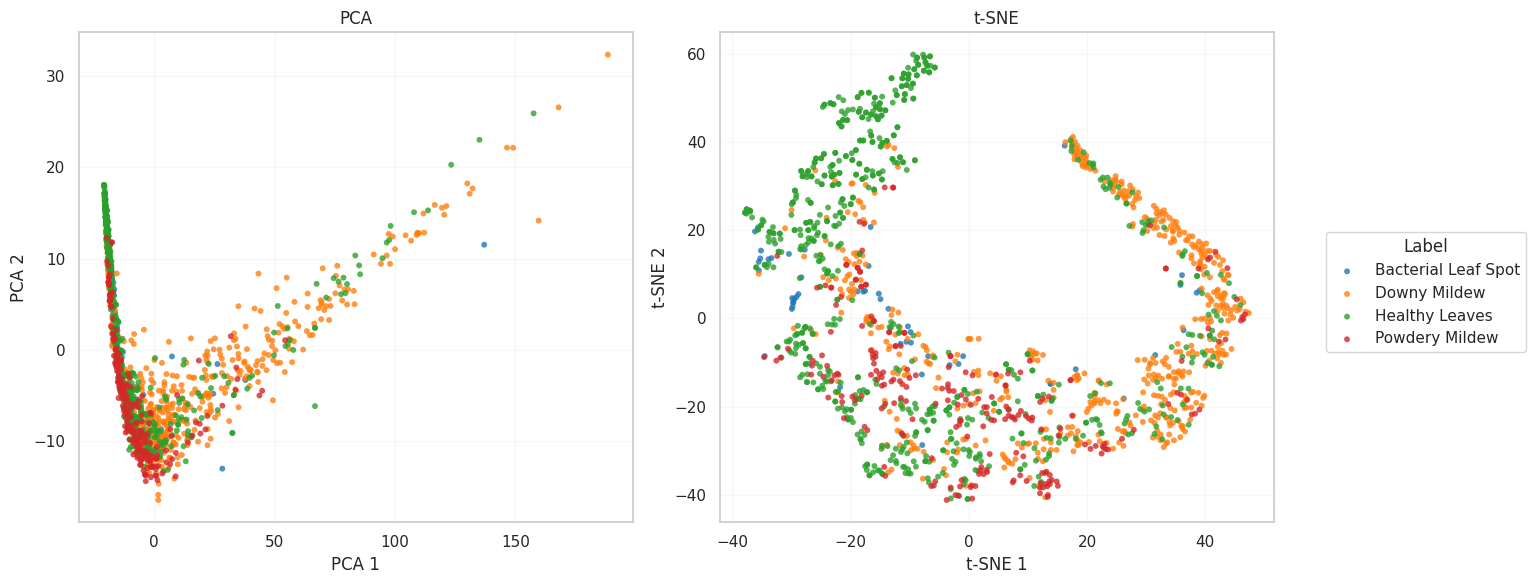

🖼️ Saved side-by-side figure as 'byol_pca_vs_tsne.png'


In [18]:
# ================================
# PCA vs t-SNE on BYOL embeddings
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from torch.utils.data import Subset

# 0) Build a labeled subset (reuse your cfg / device)
ROOT_LABELED = cfg.ROOT_TRAIN  # or cfg.PATH_VALID
eval_tf = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
labeled_ds = datasets.ImageFolder(ROOT_LABELED, transform=eval_tf)
class_names = labeled_ds.classes

idxs = list(range(len(labeled_ds)))
if getattr(cfg, "MAX_TSNE_IMAGES", None) is not None and len(idxs) > cfg.MAX_TSNE_IMAGES:
    idxs = random.sample(idxs, cfg.MAX_TSNE_IMAGES)
subset = Subset(labeled_ds, idxs)

loader = DataLoader(subset, batch_size=64, shuffle=False,
                    num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# 1) Extract BYOL features (2048-d) with frozen encoder
#    Use your trained BYOL online encoder; adjust if your var is different.
enc = model.online_enc.to(device).eval()
for p in enc.parameters(): p.requires_grad = False

feats, labs = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        f = enc(x)       # shape [B, 2048] if resnet50 with fc=Identity()
        feats.append(f.cpu().numpy()); labs.append(y.numpy())
features = np.concatenate(feats, axis=0)
labels = np.concatenate(labs, axis=0)

# 2) 2D projections
pca_2d  = PCA(n_components=2, random_state=cfg.seed).fit_transform(features)
tsne_2d = TSNE(n_components=2, perplexity=30, init="pca",
               learning_rate="auto", random_state=cfg.seed).fit_transform(features)

# 3) Silhouette scores (in 2D projected spaces)
sil_pca  = silhouette_score(pca_2d,  labels)
sil_tsne = silhouette_score(tsne_2d, labels)
print(f"Silhouette (PCA 2D):  {sil_pca:.3f}")
print(f"Silhouette (t-SNE 2D): {sil_tsne:.3f}")

# 4) Plot side-by-side
sns.set(style="whitegrid", context="notebook")
palette = sns.color_palette("tab10", n_colors=len(class_names))

fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=False, sharey=False)

def scatter(ax, Z, title):
    for ci, cname in enumerate(class_names):
        m = (labels == ci)
        ax.scatter(Z[m,0], Z[m,1], s=18, alpha=0.8, color=palette[ci], label=cname, edgecolors="none")
    ax.set_title(title)
    ax.set_xlabel(f"{title} 1")
    ax.set_ylabel(f"{title} 2")
    ax.grid(True, alpha=0.15)

scatter(axes[0], pca_2d,  "PCA")
scatter(axes[1], tsne_2d, "t-SNE")

# One legend outside for both
handles, lbls = axes[1].get_legend_handles_labels()
fig.legend(handles, lbls, title="Label", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig("byol_pca_vs_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

print("🖼️ Saved side-by-side figure as 'byol_pca_vs_tsne.png'")


In [20]:
import os, time, math, random
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
@dataclass
class CFG:
    PATH_TRAIN: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
    PATH_VALID: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
    ENCODER_PATH: str = "/kaggle/working/byol_encoder.pth"  # BYOL-pretrained encoder (from self-supervised PRETRAIN stage)

    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 0
    pin_memory: bool = False

    epochs: int = 60
    lr: float = 1e-3
    weight_decay: float = 1e-4
    warmup_epochs: int = 1
    freeze_epochs: int = 1     # freeze encoder for first N epochs, then unfreeze
    label_smoothing: float = 0.0
    seed: int = 42

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Reproducibility
# -----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
set_seed(cfg.seed)

# -----------------------
# DOWNSTREAM TASK: Supervised Dataset (classification)
# -----------------------
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2,0.2,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(cfg.PATH_TRAIN, transform=train_tf)
valid_ds = datasets.ImageFolder(cfg.PATH_VALID, transform=eval_tf)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
valid_loader = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# -----------------------
# DOWNSTREAM TASK: Load BYOL encoder and attach classifier head
# -----------------------
def build_resnet50_encoder():
    enc = models.resnet50(weights=None)
    feat_dim = enc.fc.in_features  # 2048
    enc.fc = nn.Identity()
    return enc, feat_dim

encoder, feat_dim = build_resnet50_encoder()
state = torch.load(cfg.ENCODER_PATH, map_location="cpu")
missing, unexpected = encoder.load_state_dict(state, strict=False)
print("Loaded BYOL encoder (from PRETRAIN). Missing keys:", missing, "| Unexpected:", unexpected)

class Classifier(nn.Module):
    def __init__(self, encoder, feat_dim, n_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(feat_dim, n_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)

# Full downstream model = frozen encoder + linear head
model = Classifier(encoder, feat_dim, num_classes).to(device)

# -----------------------
# DOWNSTREAM TRAINING SETUP
# -----------------------
def set_encoder_trainable(m, on: bool):
    for p in m.parameters(): p.requires_grad = on

# Start with encoder frozen (linear eval warmup)
set_encoder_trainable(model.encoder, False)

def make_optimizer(lr):
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.AdamW(params, lr=lr, weight_decay=cfg.weight_decay)

optimizer = make_optimizer(cfg.lr)
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing).to(device)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# Cosine LR schedule
def lr_at(epoch, max_epochs, base_lr, warmup_epochs=0, final_scale=0.05):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / max(1, warmup_epochs)
    t = (epoch - warmup_epochs) / max(1, max_epochs - warmup_epochs - 1)
    return base_lr * (final_scale + 0.5 * (1 - final_scale) * (1 + math.cos(math.pi * t)))

# -----------------------
# Training loop (DOWNSTREAM)
# -----------------------
BAR_FMT = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

def run_epoch(loader, train: bool, desc: str):
    model.train() if train else model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    pbar = tqdm(total=len(loader), desc=desc, leave=True, miniters=1, dynamic_ncols=True, bar_format=BAR_FMT)
    with torch.set_grad_enabled(train):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += x.size(0)
            pbar.set_postfix(loss=f"{(total_loss/total):.4f}", acc=f"{(total_correct/total)*100:.2f}%")
            pbar.update(1)
    pbar.close()
    return total_loss/total, total_correct/total

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(cfg.epochs):
    # Unfreeze encoder after N warmup epochs → full fine-tuning
    if epoch == cfg.freeze_epochs:
        set_encoder_trainable(model.encoder, True)
        optimizer = make_optimizer(cfg.lr * 0.3)

    # Update LR
    lr_now = lr_at(epoch, cfg.epochs, optimizer.param_groups[0]["lr"], warmup_epochs=cfg.warmup_epochs)
    for pg in optimizer.param_groups: pg["lr"] = lr_now

    tr_loss, tr_acc = run_epoch(train_loader, train=True,  desc=f"Epoch {epoch+1}/{cfg.epochs} (Train)")
    va_loss, va_acc = run_epoch(valid_loader, train=False, desc=f"Epoch {epoch+1}/{cfg.epochs} (Valid)")

    train_losses.append(tr_loss); valid_losses.append(va_loss)
    train_accs.append(tr_acc);    valid_accs.append(va_acc)

    print(f"Epoch {epoch+1}: Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, "
          f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}")

# -----------------------
# Final downstream evaluation
# -----------------------
final_train_acc = train_accs[-1] * 100.0
final_val_acc   = valid_accs[-1] * 100.0
print(f"\n✅ Final Train Accuracy : {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc:.2f}%\n")

# -----------------------
# Save downstream fine-tuned model
# -----------------------
torch.save(model.state_dict(), "finetuned_classifier.pth")
print("💾 Downstream fine-tuned model saved as 'finetuned_classifier.pth'")


Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
Loaded BYOL encoder (from PRETRAIN). Missing keys: [] | Unexpected: []


/tmp/ipykernel_36/896321187.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipykernel_36/896321187.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.1051, Train Acc: 0.5671, Val Loss: 1.0864, Val Acc: 0.5623


Epoch 2/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.7116, Train Acc: 0.7091, Val Loss: 0.5760, Val Acc: 0.7433


Epoch 3/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.4799, Train Acc: 0.8213, Val Loss: 0.5533, Val Acc: 0.7971


Epoch 4/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.3517, Train Acc: 0.8789, Val Loss: 1.5380, Val Acc: 0.5159


Epoch 5/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3706, Train Acc: 0.8690, Val Loss: 0.3610, Val Acc: 0.8460


Epoch 6/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.2765, Train Acc: 0.9083, Val Loss: 0.3083, Val Acc: 0.9169


Epoch 7/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.2886, Train Acc: 0.8983, Val Loss: 0.2671, Val Acc: 0.9071


Epoch 8/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.2598, Train Acc: 0.9114, Val Loss: 0.3021, Val Acc: 0.8949


Epoch 9/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.1883, Train Acc: 0.9282, Val Loss: 0.2878, Val Acc: 0.9071


Epoch 10/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.2073, Train Acc: 0.9277, Val Loss: 0.1734, Val Acc: 0.9267


Epoch 11/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.1963, Train Acc: 0.9324, Val Loss: 0.1799, Val Acc: 0.9389


Epoch 12/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.1600, Train Acc: 0.9423, Val Loss: 0.1104, Val Acc: 0.9609


Epoch 13/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.1608, Train Acc: 0.9492, Val Loss: 0.1523, Val Acc: 0.9584


Epoch 14/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.1185, Train Acc: 0.9544, Val Loss: 0.2673, Val Acc: 0.9071


Epoch 15/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.1168, Train Acc: 0.9586, Val Loss: 0.1186, Val Acc: 0.9535


Epoch 16/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.1043, Train Acc: 0.9617, Val Loss: 0.2610, Val Acc: 0.9169


Epoch 17/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.0964, Train Acc: 0.9691, Val Loss: 0.1334, Val Acc: 0.9535


Epoch 18/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.1024, Train Acc: 0.9670, Val Loss: 0.1374, Val Acc: 0.9560


Epoch 19/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.0784, Train Acc: 0.9717, Val Loss: 0.1148, Val Acc: 0.9535


Epoch 20/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.0595, Train Acc: 0.9785, Val Loss: 0.1421, Val Acc: 0.9462


Epoch 21/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 21/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.0636, Train Acc: 0.9811, Val Loss: 0.1320, Val Acc: 0.9413


Epoch 22/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 22/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.0550, Train Acc: 0.9817, Val Loss: 0.1349, Val Acc: 0.9438


Epoch 23/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 23/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.0434, Train Acc: 0.9885, Val Loss: 0.0982, Val Acc: 0.9609


Epoch 24/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 24/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.0485, Train Acc: 0.9827, Val Loss: 0.1247, Val Acc: 0.9462


Epoch 25/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 25/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.0393, Train Acc: 0.9874, Val Loss: 0.1083, Val Acc: 0.9487


Epoch 26/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 26/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.0563, Train Acc: 0.9780, Val Loss: 0.1226, Val Acc: 0.9511


Epoch 27/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 27/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.0484, Train Acc: 0.9848, Val Loss: 0.1224, Val Acc: 0.9511


Epoch 28/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 28/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.0500, Train Acc: 0.9801, Val Loss: 0.1146, Val Acc: 0.9487


Epoch 29/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 29/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.0462, Train Acc: 0.9848, Val Loss: 0.1248, Val Acc: 0.9487


Epoch 30/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 30/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.0380, Train Acc: 0.9885, Val Loss: 0.1195, Val Acc: 0.9462


Epoch 31/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 31/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31: Train Loss: 0.0411, Train Acc: 0.9864, Val Loss: 0.1178, Val Acc: 0.9438


Epoch 32/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 32/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32: Train Loss: 0.0329, Train Acc: 0.9900, Val Loss: 0.1191, Val Acc: 0.9511


Epoch 33/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 33/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33: Train Loss: 0.0361, Train Acc: 0.9885, Val Loss: 0.1023, Val Acc: 0.9535


Epoch 34/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 34/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34: Train Loss: 0.0355, Train Acc: 0.9911, Val Loss: 0.1310, Val Acc: 0.9511


Epoch 35/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 35/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35: Train Loss: 0.0395, Train Acc: 0.9879, Val Loss: 0.0988, Val Acc: 0.9535


Epoch 36/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 36/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36: Train Loss: 0.0414, Train Acc: 0.9858, Val Loss: 0.1116, Val Acc: 0.9511


Epoch 37/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 37/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37: Train Loss: 0.0346, Train Acc: 0.9900, Val Loss: 0.1107, Val Acc: 0.9535


Epoch 38/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 38/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38: Train Loss: 0.0393, Train Acc: 0.9858, Val Loss: 0.1044, Val Acc: 0.9487


Epoch 39/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 39/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39: Train Loss: 0.0425, Train Acc: 0.9879, Val Loss: 0.1171, Val Acc: 0.9511


Epoch 40/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 40/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40: Train Loss: 0.0474, Train Acc: 0.9838, Val Loss: 0.1210, Val Acc: 0.9462


Epoch 41/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 41/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41: Train Loss: 0.0391, Train Acc: 0.9879, Val Loss: 0.1144, Val Acc: 0.9535


Epoch 42/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 42/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42: Train Loss: 0.0485, Train Acc: 0.9827, Val Loss: 0.0997, Val Acc: 0.9560


Epoch 43/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 43/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43: Train Loss: 0.0429, Train Acc: 0.9858, Val Loss: 0.1347, Val Acc: 0.9462


Epoch 44/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 44/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44: Train Loss: 0.0396, Train Acc: 0.9853, Val Loss: 0.1109, Val Acc: 0.9535


Epoch 45/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 45/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45: Train Loss: 0.0398, Train Acc: 0.9869, Val Loss: 0.1169, Val Acc: 0.9462


Epoch 46/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 46/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46: Train Loss: 0.0364, Train Acc: 0.9874, Val Loss: 0.1238, Val Acc: 0.9438


Epoch 47/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 47/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47: Train Loss: 0.0380, Train Acc: 0.9853, Val Loss: 0.1135, Val Acc: 0.9511


Epoch 48/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 48/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48: Train Loss: 0.0383, Train Acc: 0.9853, Val Loss: 0.1303, Val Acc: 0.9487


Epoch 49/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 49/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49: Train Loss: 0.0370, Train Acc: 0.9916, Val Loss: 0.1225, Val Acc: 0.9487


Epoch 50/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 50/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50: Train Loss: 0.0363, Train Acc: 0.9869, Val Loss: 0.1051, Val Acc: 0.9535


Epoch 51/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 51/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 51: Train Loss: 0.0440, Train Acc: 0.9864, Val Loss: 0.1054, Val Acc: 0.9511


Epoch 52/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 52/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 52: Train Loss: 0.0508, Train Acc: 0.9806, Val Loss: 0.1248, Val Acc: 0.9438


Epoch 53/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 53/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 53: Train Loss: 0.0413, Train Acc: 0.9832, Val Loss: 0.1018, Val Acc: 0.9535


Epoch 54/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 54/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 54: Train Loss: 0.0338, Train Acc: 0.9927, Val Loss: 0.0985, Val Acc: 0.9535


Epoch 55/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 55/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 55: Train Loss: 0.0434, Train Acc: 0.9869, Val Loss: 0.1279, Val Acc: 0.9438


Epoch 56/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 56/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 56: Train Loss: 0.0337, Train Acc: 0.9911, Val Loss: 0.1039, Val Acc: 0.9535


Epoch 57/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 57/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 57: Train Loss: 0.0451, Train Acc: 0.9853, Val Loss: 0.1144, Val Acc: 0.9487


Epoch 58/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 58/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 58: Train Loss: 0.0425, Train Acc: 0.9858, Val Loss: 0.1187, Val Acc: 0.9487


Epoch 59/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 59/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 59: Train Loss: 0.0523, Train Acc: 0.9806, Val Loss: 0.1196, Val Acc: 0.9438


Epoch 60/60 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 60/60 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60: Train Loss: 0.0417, Train Acc: 0.9885, Val Loss: 0.1113, Val Acc: 0.9487

✅ Final Train Accuracy : 98.85%
✅ Final Validation Accuracy : 94.87%

💾 Downstream fine-tuned model saved as 'finetuned_classifier.pth'


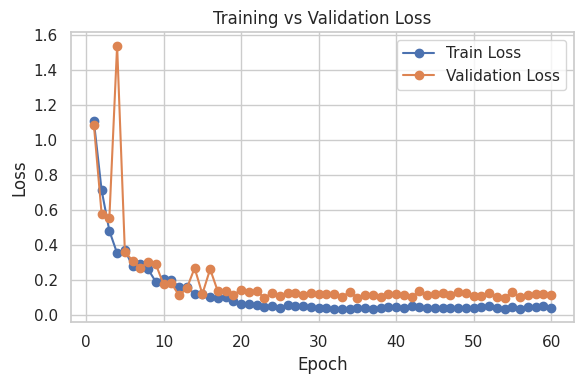

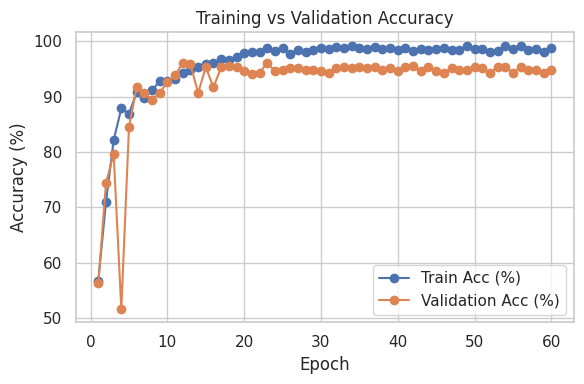

In [21]:
# -----------------------
# Plots: Train vs Validation
# -----------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, cfg.epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, cfg.epochs+1), valid_losses, marker='o', label='Validation Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("train_val_loss.png", dpi=300); plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, cfg.epochs+1), [a*100 for a in train_accs], marker='o', label='Train Acc (%)')
plt.plot(range(1, cfg.epochs+1), [a*100 for a in valid_accs], marker='o', label='Validation Acc (%)')
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Training vs Validation Accuracy")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("train_val_acc.png", dpi=300); plt.show()

In [22]:
# ========= 2.4 Downstream Fine-tuning — LAST PART: TEST EVALUATION =========
# Uses fine-tuned model weights: /kaggle/working/finetuned_classifier.pth

import os, time, itertools, math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.preprocessing import label_binarize

# -----------------------
# Paths & config
# -----------------------
FINETUNED_PATH = "/kaggle/working/finetuned_classifier.pth"
PATH_TEST = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = False
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# -----------------------
# Data (test only)
# -----------------------
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = datasets.ImageFolder(PATH_TEST, transform=eval_tf)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
class_names = test_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# -----------------------
# Rebuild model exactly like fine-tuning: encoder + linear head
# -----------------------
def build_resnet50_encoder():
    enc = models.resnet50(weights=None)
    feat_dim = enc.fc.in_features  # 2048
    enc.fc = nn.Identity()
    return enc, feat_dim

class Classifier(nn.Module):
    def __init__(self, encoder, feat_dim, n_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(feat_dim, n_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)

encoder, feat_dim = build_resnet50_encoder()
model = Classifier(encoder, feat_dim, num_classes).to(device)

# Load fine-tuned weights
state = torch.load(FINETUNED_PATH, map_location="cpu")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded fine-tuned model. Missing keys:", missing, "| Unexpected:", unexpected)

# -----------------------
# Helper: collect logits/targets
# -----------------------
@torch.no_grad()
def collect_logits_targets(loader):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y)
    return torch.cat(all_logits), torch.cat(all_targets)

# -----------------------
# TEST EVALUATION + timing
# -----------------------
t_test_start = time.time()
test_logits, test_targets = collect_logits_targets(test_loader)
t_test_end = time.time()
test_time_sec = t_test_end - t_test_start

test_probs = torch.softmax(test_logits, dim=1).numpy()
test_preds = test_logits.argmax(dim=1).numpy()
test_targets_np = test_targets.numpy()

# Overall Test Accuracy
test_acc = accuracy_score(test_targets_np, test_preds)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"⏱️ Testing time: {test_time_sec:.1f} seconds")




Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
Loaded fine-tuned model. Missing keys: [] | Unexpected: []

✅ Test Accuracy: 92.42%
⏱️ Testing time: 5.8 seconds


Class 'Bacterial Leaf Spot': accuracy = 93.33%
Class 'Downy Mildew': accuracy = 88.97%
Class 'Healthy Leaves': accuracy = 100.00%
Class 'Powdery Mildew': accuracy = 77.05%

Classification Report (per-class):
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.88      0.93      0.90        15
       Downy Mildew       0.96      0.89      0.92       145
     Healthy Leaves       0.92      1.00      0.96       188
     Powdery Mildew       0.87      0.77      0.82        61

           accuracy                           0.92       409
          macro avg       0.91      0.90      0.90       409
       weighted avg       0.92      0.92      0.92       409

Macro   Precision/Recall/F1: 0.906 / 0.898 / 0.901
Micro   Precision/Recall/F1: 0.924 / 0.924 / 0.924
Weighted Precision/Recall/F1: 0.925 / 0.924 / 0.923


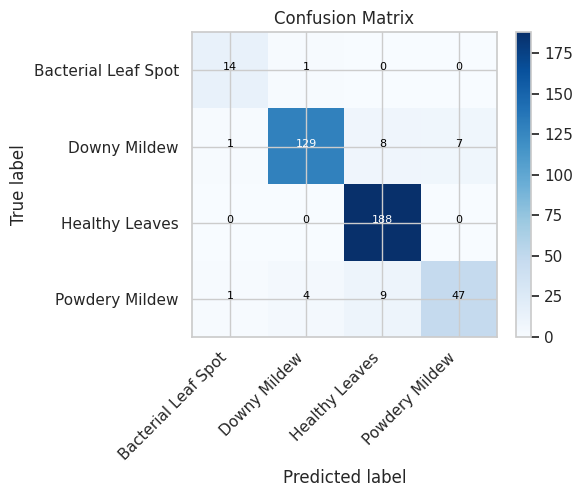

🖼️ Saved 'confusion_matrix.png'


In [23]:
# Per-class Accuracy
cm = confusion_matrix(test_targets_np, test_preds, labels=list(range(num_classes)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
for i, cname in enumerate(class_names):
    print(f"Class '{cname}': accuracy = {per_class_acc[i]*100:.2f}%")

# Precision / Recall / F1 (macro, micro, weighted) + per-class table
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='macro', zero_division=0)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='micro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='weighted', zero_division=0)

from sklearn.metrics import classification_report
print("\nClassification Report (per-class):")
print(classification_report(test_targets_np, test_preds, target_names=class_names, zero_division=0))

print(f"Macro   Precision/Recall/F1: {prec_macro:.3f} / {rec_macro:.3f} / {f1_macro:.3f}")
print(f"Micro   Precision/Recall/F1: {prec_micro:.3f} / {rec_micro:.3f} / {f1_micro:.3f}")
print(f"Weighted Precision/Recall/F1: {prec_weighted:.3f} / {rec_weighted:.3f} / {f1_weighted:.3f}")




# -----------------------
# Confusion Matrix plot
# -----------------------
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=8)
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300); plt.show()
print("🖼️ Saved 'confusion_matrix.png'")


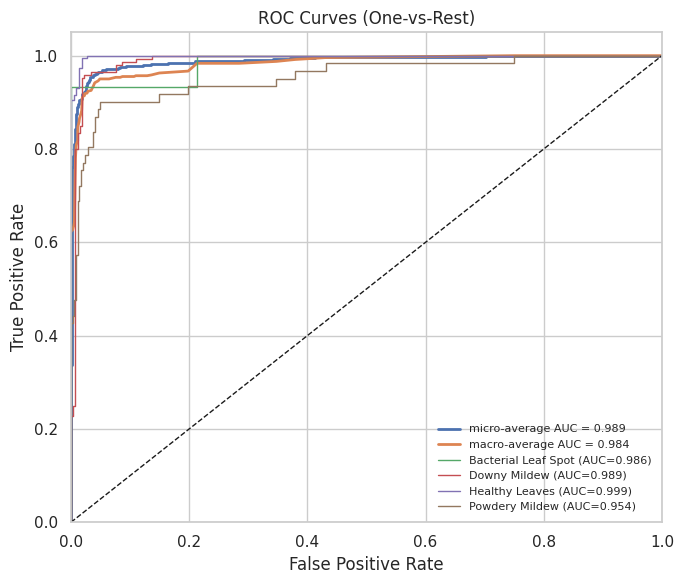

🖼️ Saved 'roc_auc_curves.png'


In [24]:
# -----------------------
# ROC curves + AUC (One-vs-Rest)
# -----------------------
# Binarize labels for ROC/AUC
y_true_bin = label_binarize(test_targets_np, classes=list(range(num_classes)))
if y_true_bin.shape[1] == 1:
    # In binary case, expand to 2 columns for ROC plotting
    y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

fpr = {}; tpr = {}; roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), test_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average AUC = {roc_auc['micro']:.3f}", linewidth=2)
plt.plot(all_fpr, mean_tpr, label=f"macro-average AUC = {roc_auc['macro']:.3f}", linewidth=2)
for i, cname in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"{cname} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(fontsize=8, loc="lower right", frameon=False)
plt.tight_layout()
plt.savefig("roc_auc_curves.png", dpi=300); plt.show()
print("🖼️ Saved 'roc_auc_curves.png'")


